# Forecasting Bitcoin Prices

## Introduction
In 2008, **Bitcoin** took the world by storm as the world's first decentralized cryptocurrency. Since then, Bitcoin has gone from a worthless digital currency to costing nearly $20,000 at its highest peak. It is understandable, then, that many have tried to **forecast the price of Bitcoin** over the years with the hope of profiting off of the currency's success.

In this project, we will attempt to forecast the price of Bitcoin using both simple and long short-term memory (**LSTM**) recurrent neural networks (**RNNs**), as well as **Facebook's Prophet** software. We will compare the relative accuracy of these predictive models in forecasting Bitcoin's 2020 prices based on historical prices, then attempt to forecast future prices using our most promising models.

## Setup
In this section, we will set up our environment by importing libraries, managing packages, and writing utility functions for later use.

**Note:** this project was developed in Google’s Colaboratory environment, so some of the setup code is specific to Colab’s environment. For example, we will load the data from a mounted Google Drive rather than from our GitHub repository, as the file size exceeds GitHub’s limit.

### Imports

In [109]:
# Core data science libraries
from datetime import datetime as dt
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Plotting 
mpl.rcParams['figure.figsize'] = (12,8)
sns.set_theme(style='whitegrid')
plt.style.use('ggplot')

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler

# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Model Selection
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Facebook Prophet
from fbprophet import Prophet

# Ensure that pandas dataframs are able to print
pd.set_option('display.max_columns', 10)

### Loading the Data
This project will make use of a [Bitcoin dataset](https://www.kaggle.com/mczielinski/bitcoin-historical-data) provided by Zielak on Kaggle. The data was scraped from various cryptocurrency exchange APIs. 

Due to the large size of the data file (280 MB), we will need to load the data from our Google Drive or local computer rather than from the project's GitHub repository.

In [5]:
# Importing data
data_path = '/content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin/bitcoin.csv'
bitcoin = pd.read_csv(data_path)
print(bitcoin.head())

    Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN  


## Data Preprocessing and Analysis

We see that each row of our dataset provides information on the different types of Bitcoin prices and volumes at a given time. The `Weighted_Price` column contains a weighted average of the `Open`, `High`, `Low`, and `Close` prices, and so we will use this as our primary measure of Bitcoin price. 

Since we have some missing values in the dataset, we will drop the rows for which the `Weighted_Price` is missing. We will drop the rows altogether rather than imputing the missing values, as our dataset contains multiple timestamps for each day. We will analyze daily Bitcoin prices, so it should be preferable for us to drop the rows altogether. 

In [6]:
bitcoin = bitcoin.dropna(subset=['Weighted_Price'])
print(bitcoin.head())

       Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0     1325317920  4.39  4.39  4.39   4.39      0.455581           2.000000   
478   1325346600  4.39  4.39  4.39   4.39     48.000000         210.720000   
547   1325350740  4.50  4.57  4.50   4.57     37.862297         171.380338   
548   1325350800  4.58  4.58  4.58   4.58      9.000000          41.220000   
1224  1325391360  4.58  4.58  4.58   4.58      1.502000           6.879160   

      Weighted_Price  
0           4.390000  
478         4.390000  
547         4.526411  
548         4.580000  
1224        4.580000  


Next, we must decode the timestamps. The `Timestamp` column contains information on the second at which a row's data were collected. We can use `pandas` to decode this information into the `datetime` format. 

In [7]:
# Decode timestamp
bitcoin['Timestamp'] = pd.to_datetime(bitcoin['Timestamp'], unit='s')

# Date column
bitcoin['Date'] = bitcoin['Timestamp'].dt.date

print(bitcoin.head())

               Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0    2011-12-31 07:52:00  4.39  4.39  4.39   4.39      0.455581   
478  2011-12-31 15:50:00  4.39  4.39  4.39   4.39     48.000000   
547  2011-12-31 16:59:00  4.50  4.57  4.50   4.57     37.862297   
548  2011-12-31 17:00:00  4.58  4.58  4.58   4.58      9.000000   
1224 2012-01-01 04:16:00  4.58  4.58  4.58   4.58      1.502000   

      Volume_(Currency)  Weighted_Price        Date  
0              2.000000        4.390000  2011-12-31  
478          210.720000        4.390000  2011-12-31  
547          171.380338        4.526411  2011-12-31  
548           41.220000        4.580000  2011-12-31  
1224           6.879160        4.580000  2012-01-01  


We now have data on the date of each price recorded in our dataset. As mentioned, we may have multiple datapoints for each date, so we will now group the data by date and take the average of weighted price. 

In [8]:
# Group weighted price by date
bitcoin = bitcoin.groupby('Date')['Weighted_Price'].mean().reset_index()
print(bitcoin.head())

         Date  Weighted_Price
0  2011-12-31        4.471603
1  2012-01-01        4.806667
2  2012-01-02        5.000000
3  2012-01-03        5.252500
4  2012-01-04        5.208159


We have also done away with the columns we are not interested in, so now we have a simple dataset that provides the `Weighted_Price` of Bitcoin on each `Date`. Now that we have the price of Bitcoin on each date, let's visualize the overall data to get a sense for Bitcoin's trend.

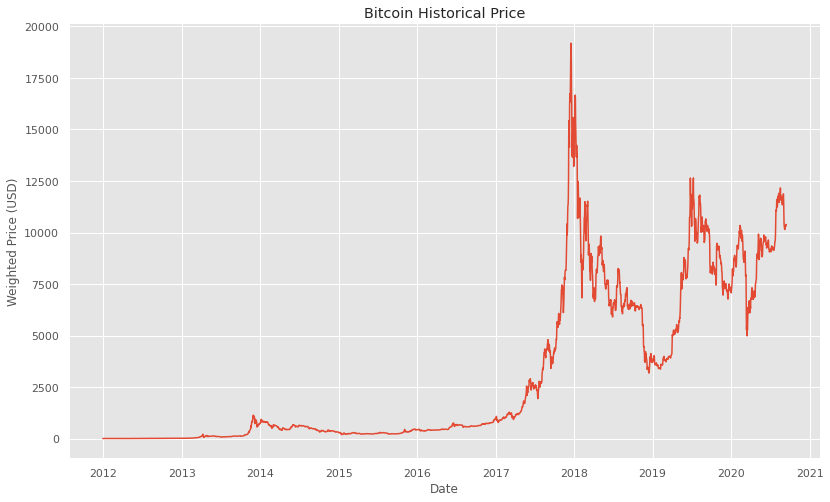

In [110]:
# Plot Historical Price (Close)
sns.lineplot(x=bitcoin['Date'], y=bitcoin['Weighted_Price'])
plt.title('Bitcoin Historical Price')
plt.ylabel('Weighted Price (USD)');

We can see that at the end of 2017, Bitcoin prices soared to nearly $20,000. Since then, it has seen dramatic fluctuations, which will make our task very interesting. 

### Creating time-series datasets
As we will perform time-series analyses, we must prepare our data for our RNN and LSTM models. The train and test datasets will need to take a 3 dimensional shape: (# values, # timesteps, # variable output). In our case, our y values will be individual Bitcoin prices, and our X values will be Bitcoin prices on the preceding 60 days. 

Here is an illustrative example of one input/sample for our RNN model: we will try to predict the Weighted_Price on January 1st, 2020 using the prices of the 60 days before January 1st. Our dataset will include such X/y pairs for all dates of interest. 

Before we use our predictive models to forecast future Bitcoin prices, we will try to predict the year-to-date (YTD) prices for 2020. Therefore, we will split our data into a training set that contains data from before 2020 and a test set that contains data from 2020. 

In [10]:
# We will need to scale our data, so we will instantiate our scaler
scaler = MinMaxScaler()

The function below will generate train and test datasets based on a split date and number of timesteps. We have set default values for our purpose, so the function with default parameters will split 2020 data into the test set and use 60 days of lookback data for all predictions. 

In [11]:
def create_datasets(split_date = '2020-01-01', timesteps = 60):
  """
  Create training and test datasets. Function will create a training set
  that covers a user-defined lookback period

  Create X and y data for training set; each y_train value will represent a price,
  and each entry in X_train will contain the 60 (set by timesteps parameter) prices
  that precede the price in y_train

  In essence, for each data sample, our neural network will learn to predict a 
  bitcoin price on a given date based on the prices from the preceding 60 days
  """
  # Find the index of the split date
  split = dt.strptime(split_date, '%Y-%m-%d').date()
  split_index = bitcoin[bitcoin['Date'] == split].index.values[0]

  # Split into train and test datasets based on split date
  btc_train = bitcoin.iloc[ : split_index]
  train = btc_train.values[:, 1]
  btc_test = bitcoin.iloc[split_index : ]
  test = btc_test.values[:, 1]

  # Scale the data 
  train = scaler.fit_transform(train.reshape(-1, 1))
  test = scaler.transform(test.reshape(-1, 1))

  # Preparing the train data as described
  X_train = []
  y_train = []
  for i in range(timesteps, len(train)):
    X_train.append(train[(i-timesteps) : i]) # Prices of previous # days
    y_train.append(train[i]) # Price on this particular day
  X_train, y_train = np.array(X_train), np.array(y_train)
  # Reshape the data in the format (# values, # timesteps, # univariate output)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  # Repeat the process for test data
  X_test = []
  y_test = []
  for i in range(timesteps, len(test)):
    X_test.append(test[(i-timesteps) : i]) # Prices of previous # days
    y_test.append(test[i]) # Price on this particular day
  X_test, y_test = np.array(X_test), np.array(y_test)
  # Reshape the data in the format (# values, # timesteps, # univariate output)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
  return btc_train, btc_test, X_train, y_train, X_test, y_test


btc_train, btc_test, X_train, y_train, X_test, y_test = create_datasets()

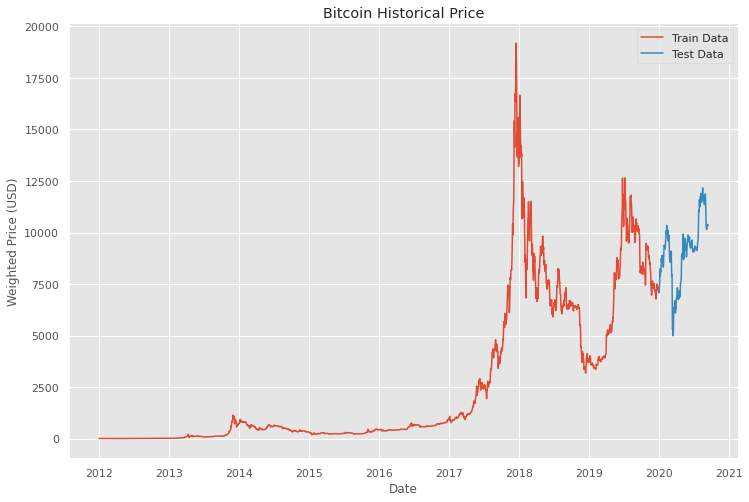

In [12]:
fig, ax = plt.subplots()
sns.lineplot(x = btc_train['Date'], y = btc_train['Weighted_Price'], ax=ax)
sns.lineplot(x = btc_test['Date'], y = btc_test['Weighted_Price'], ax = ax)
ax.legend(labels = ['Train Data', 'Test Data'])
ax.set_title('Bitcoin Historical Price')
ax.set_ylabel('Weighted Price (USD)')
ax.set_xlabel('Date');

## Forecasting 2020 Bitcoin Prices
We will now use our train and test sets to forecast the Bitcoin prices for 2020, and compare our predictions to actual data. This will allow us to compare the accuracy of multiple models. 

The function below will allow us to quickly fit keras deep learning models and visualize results. We will use root mean squared error (RMSE) as our objective measure of loss. 

In [13]:
def forecast(model, X_train = X_train, y_train = y_train, X_test = X_test,
            y_test = y_test, optimizer = 'adam',
            epochs = 50, batch_size = 32):
  """ 
  Build, compile, and fit a provided neural network with train and test data, 
  then make forecast predictions and return results
  """
  # Define early stopping callback and compile provided model
  early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=5,
                                 restore_best_weights = True)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  # Fit the model 
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                      callbacks = [early_stopping])

  # Make predictions on 'future' data
  y_pred = model.predict(X_test)
  # We must reverse the MinMaxScaler transformation
  y_pred = scaler.inverse_transform(y_pred)
  y_test = scaler.inverse_transform(y_test)

  # Scoring the predictions
  #mse = mean_squared_error(btc_test['Weighted_Price'].iloc[60:], y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  print("RMSE: {:.2f}".format(rmse))

  # Visualize the forecast
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), sharey=True)

  # Actual vs. predicted price over entire history
  sns.lineplot(x = bitcoin['Date'], y = bitcoin['Weighted_Price'], ax =ax1)
  sns.lineplot(x = btc_test['Date'].iloc[60:], y = y_pred[:, 0], ax = ax1)
  ax1.legend(labels = ['Actual Price', 'Predicted Price'])
  ax1.set_title('Bitcoin Price Forecast')
  ax1.set_ylabel('Weighted Price (USD)')
  ax1.set_xlabel('Date')

  # Actual vs. predicted price in forecasted time period

  sns.lineplot(x = btc_test['Date'].iloc[60:],
              y = btc_test['Weighted_Price'].iloc[60:], ax=ax2)
  sns.lineplot(x = btc_test['Date'].iloc[60:], y = y_pred[:, 0], ax = ax2)
  ax2.legend(labels = ['Actual Price', 'Predicted Price'])
  ax2.set_title('Bitcoin Price Forecast')
  ax2.set_ylabel('Weighted Price (USD)')
  ax2.set_xlabel('Date');
  
  return y_test, y_pred 

### Recurrent Neural Networks (RNNs)
We will apply RNN models, which are a broad class of deep neural networks that are typically used for applications that involve sequence data, such as time-series data. 

With feed-forward neural networks, information moves in one direction (input > hidden layers > output). In contrast to feed-forward networks, RNNs use loops, allowing hidden layer outputs to be used as inputs that are fed back into the hidden layers. This allows RNNs to use sequence information and, in a sense, have memory that considers prior inputs. In our case, this will allow our neural networks to make predictions on Bitcoin prices based on time-series data; our RNNs will be able to sequentially learn how Bitcoin prices change and, in turn, how these sequential changes lead to different y values [[Image Source](https://www.researchgate.net/figure/Feed-forward-and-recurrent-neural-networks_fig5_305881131)].



#### Simple RNN
We will first build a very simple RNN that consists of a single RNN input layer and a Dense output layer. The Dense output layer has 1 neuron, which will be used to output our predictions. This simple RNN will serve as a comparator for our LSTM model, which we will build next.  

Epoch 1/50
90/90 [==============================] - 5s 49ms/step - loss: 0.0089
Epoch 2/50
90/90 [==============================] - 4s 49ms/step - loss: 0.0046
Epoch 3/50
90/90 [==============================] - 4s 49ms/step - loss: 0.0041
Epoch 4/50
90/90 [==============================] - 5s 50ms/step - loss: 0.0030
Epoch 5/50
90/90 [==============================] - 4s 50ms/step - loss: 0.0023
Epoch 6/50
90/90 [==============================] - 4s 49ms/step - loss: 0.0019
RMSE: 2336.45


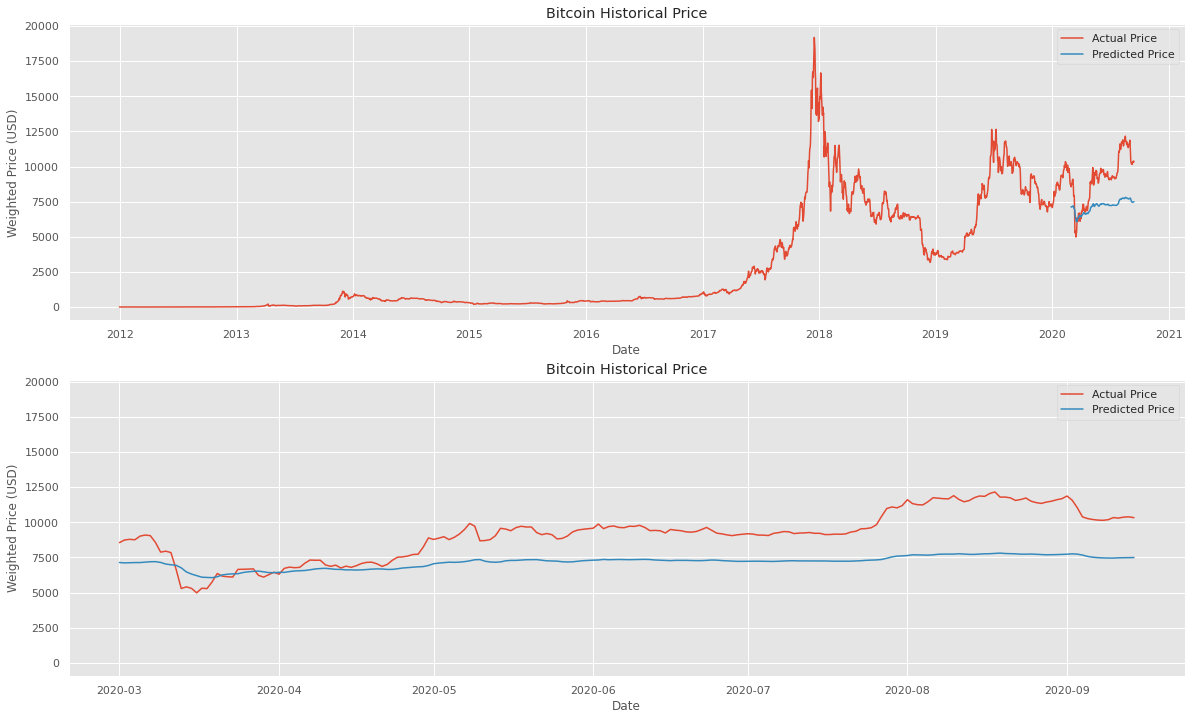

In [14]:
simple_rnn = Sequential([
      SimpleRNN(1, input_shape = (X_train.shape[1], 1)),
      Dense(1)
])
y_test, y_pred_rnn = forecast(simple_rnn)

We have presented two graphs here: the top graph shows the entire history of Bitcoin data, while the bottom graph zooms in on the 2020 data. 

Based on the graph of the historical trend, it appears that our RNN did not predict the trend of Bitcoin prices very well. There was a large drop in prices at the start of our test period, which our model did not seem to predict. Overall, it appears that our model seems to have averaged the price data over time, rather than actually predicting how the price will change. 

One limitation of RNNs is that they face the **vanishing gradient** problem, which leads to RNNs having an issue of short-term memory. In short, as RNNs loop and process outputs as inputs, gradients have a tendency to become increasingly small during backpropogation. When gradients become smaller and smaller during backpropogation, the changes made to the neural network are also small, meaning that the neural network makes only small adjustments and therefore does not learn the training data properly. 

Due to vanishing gradients, RNNs tend to have trouble retaining information from earlier steps in the sequence. This is likely the reason why our model did not make significant changes to the predicted price in either direction, even though prices did often increase or decrease drastically. 



#### Long Short-Term Memory (LSTM) RNN
LSTMs are a subclass of RNNs that seeks to combat the problem of vanishing gradients and short-term memory. LSTMs contain "gates", which are mechanisms that allow the LSTM to either keep or throw out previous data as the RNN runs loops. These gates, therefore, serve as the memory system for the LSTMs, and allow these models to integrate learnings from earlier values in the sequences. In our case, this will allow our Bitcoin forecasting model to hold on to information about earlier Bitcoin prices (specifically, up to 60 days before the price we are trying to predict). In the process of backpropogation, our models can learn to either forget or retain specific information based on how valuable it is for the purpose of predicting future outcomes. [[Image Source](https://link.springer.com/chapter/10.1007/978-3-030-15986-3_3)].

https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-15986-3_3/MediaObjects/480826_1_En_3_Fig1_HTML.png

We will build a relatively simple, single-layer LSTM with tanh activation function (this is the most popular option) and 128 neurons. As with the simple RNN, we will use data from before 2020 to train the model and use the model to predict prices of Bitcoin in 2020; for each day in 2020, our model will predict the price based on the prices of the preceding 60 days. 

Epoch 1/50
90/90 [==============================] - 3s 6ms/step - loss: 0.0101
Epoch 2/50
90/90 [==============================] - 0s 5ms/step - loss: 4.4352e-04
Epoch 3/50
90/90 [==============================] - 0s 5ms/step - loss: 4.8926e-04
Epoch 4/50
90/90 [==============================] - 1s 6ms/step - loss: 4.1696e-04
Epoch 5/50
90/90 [==============================] - 0s 5ms/step - loss: 3.2920e-04
Epoch 6/50
90/90 [==============================] - 0s 6ms/step - loss: 2.9563e-04
RMSE: 616.93


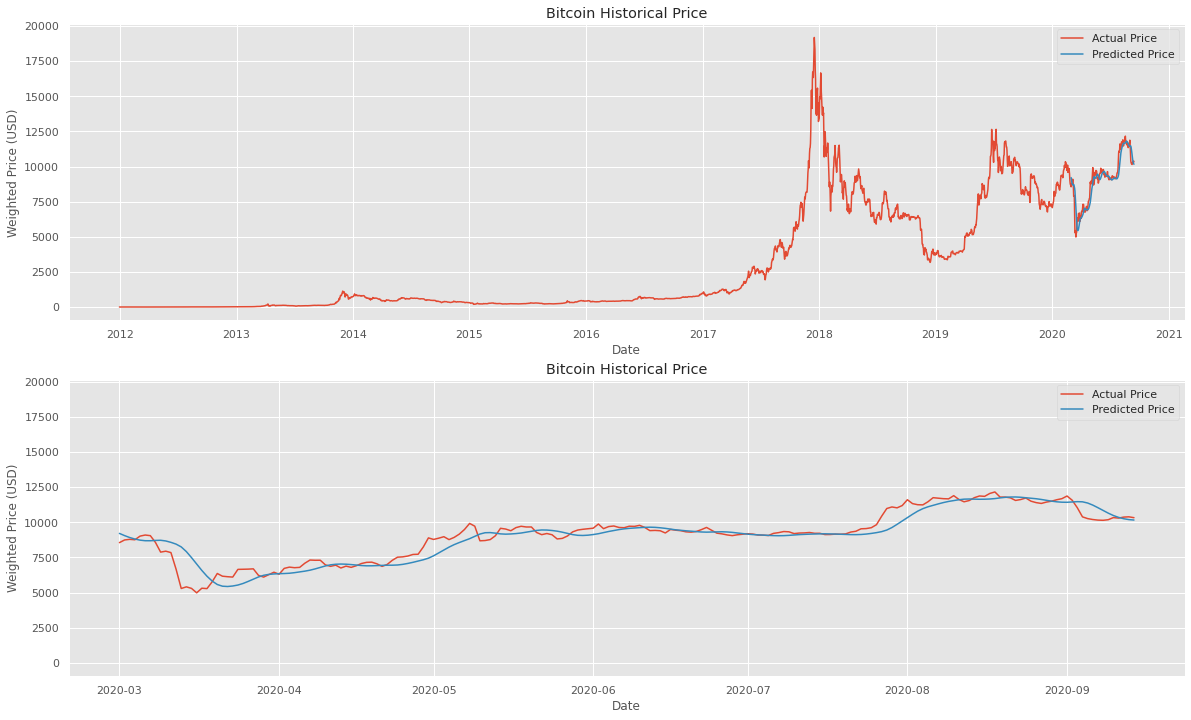

In [15]:
lstm = Sequential([
      LSTM(128, activation='tanh', input_shape = (X_train.shape[1], 1)),
      Dense(1)
])
y_test, y_pred_lstm = forecast(lstm)

In contrast to our simple RNN, which was not able to sufficiently learn the trends of Bitcoin prices, it appears that our LSTM model did an excellent job of predicting Bitcoin prices. We can see from our bottom graph, which focuses on the test period, that the predictions follow the trend of actual prices very closely, with a slight temporal delay. Overall, this model appears to have performed very well, especially when comparing to the simple RNN. 

Best of all, this model was relatively easy and quick to train and only consists of one layer. While the concept of the LSTM is complex compared to feed-forward networks, the implementation was nonetheless very easy. This shows great promise for more advanced LSTM models, which may be able to improve further on this performance. 

### Facebook Prophet
The last model we will consider is [Facebook's open-source Prophet framework](https://facebook.github.io/prophet/). Prophet is a time-series forecasting procedure that is able to fit non-linear trends using an additive model that takes into consideration yearly, weekly, and daily seasonality, as well as holidays. Prophet has shown great promise in recent years as a fast and powerful framework for making time-series predictions, and it is also very useful because it has out-of-box capabilities for taking seasonality and holidays into account. 

One benefit of Prophet is that it requires minimal data preprocessing. We previously prepared train and test datasets for our RNN models, but Prophet's requirements are more lenient and thus we can use more intuitive data structures (such as our 2 column dataframes) as inputs. 


In [16]:
# Prophet expects columns with names 'ds' and 'y'
train_df = btc_train
train_df.columns = ['ds', 'y']
print('Train data: \n', train_df.head(), '\n')

test_df = btc_test.copy()
test_df.columns = ['ds', 'y']
print('Test data: \n', test_df.head())

Train data: 
            ds         y
0  2011-12-31  4.471603
1  2012-01-01  4.806667
2  2012-01-02  5.000000
3  2012-01-03  5.252500
4  2012-01-04  5.208159 

Test data: 
               ds            y
2920  2020-01-01  7195.811553
2921  2020-01-02  7072.477634
2922  2020-01-03  7218.040867
2923  2020-01-04  7321.919471
2924  2020-01-05  7430.027210


The function below will allow us to configure and fit Prophet models and reproduce this process with different datasets. The function will also plot custom visualizations for our purpose. 

In [52]:
def prophet_forecast(train, test):
  """ 
  Configure and fit a Prophet model with train and test data, 
  make forecast predictions and return score, and visualize forecast.
  """
  # Set Prophet Parameters
  prophet_parameters = {
    'yearly_seasonality' : 'auto',
    'weekly_seasonality' : 'auto',
    'daily_seasonality' : True,
    'changepoint_prior_scale' : 0.1,
  }

  # Fit prophet model
  m = Prophet(**prophet_parameters)
  m.fit(train)

  # Make predictions
  predictions = m.predict(test)
  y_test = test['y']
  y_pred = predictions['yhat']

  # Scoring the predictions
  mse = mean_squared_error(test['y'], y_pred)
  rmse = np.sqrt(mse)
  print("RMSE: {:.2f}".format(rmse))

  # Visualize the forecast
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), sharey=True)

  # Actual vs. predicted price over entire history
  sns.lineplot(x = bitcoin['Date'], y = bitcoin['Weighted_Price'], ax =ax1)
  sns.lineplot(x = predictions['ds'], y = predictions['yhat'], ax = ax1)
  ax1.fill_between(predictions['ds'], predictions['yhat_lower'],
                  predictions['yhat_upper'], alpha = 0.2, color = 'b')
  ax1.legend(labels = ['Actual Price', 'Predicted Price'])
  ax1.legend(labels = ['Actual Price', 'Predicted Price'])
  ax1.set_title('Bitcoin Price Forecast')
  ax1.set_ylabel('Weighted Price (USD)')
  ax1.set_xlabel('Date')


  sns.lineplot(x = test['ds'], y = test['y'], ax=ax2)
  sns.lineplot(x = predictions['ds'], y = predictions['yhat'], ax = ax2)
  ax2.fill_between(predictions['ds'], predictions['yhat_lower'],
                   predictions['yhat_upper'], alpha = 0.2, color = 'b')
  ax2.legend(labels = ['Actual Price', 'Predicted Price'])
  ax2.set_title('Bitcoin Price Forecast')
  ax2.set_ylabel('Weighted Price (USD)')
  ax2.set_xlabel('Date');
  
  return y_test, y_pred 

RMSE: 1141.98


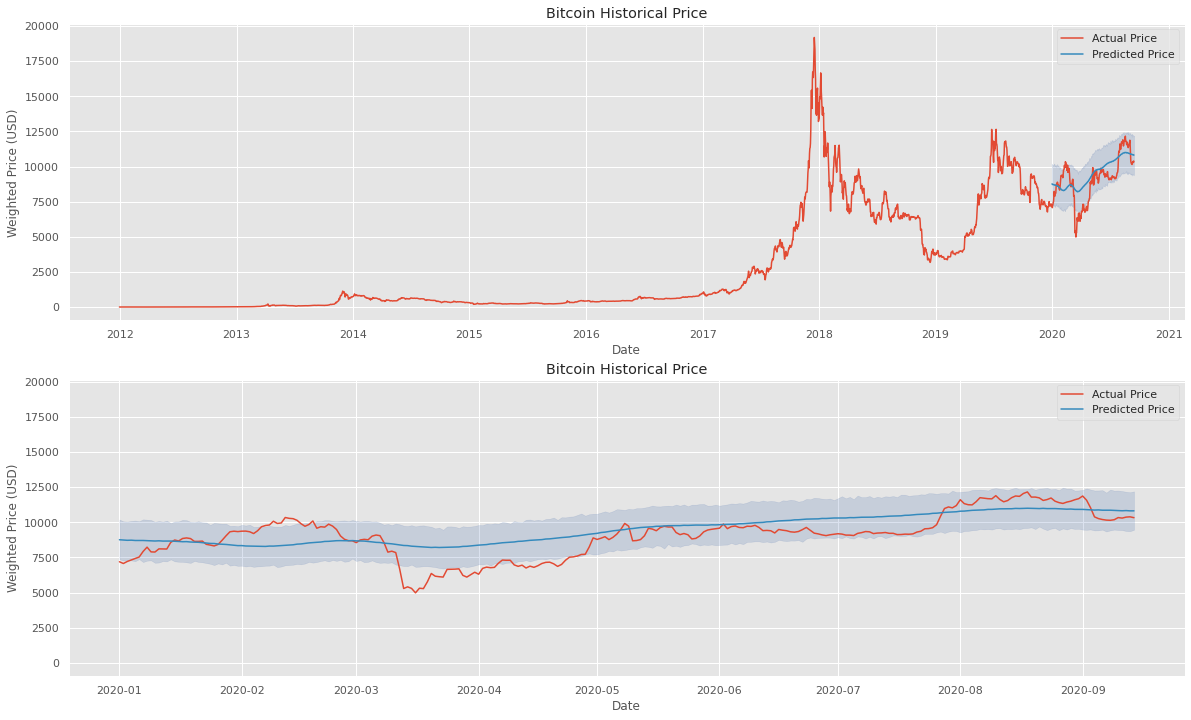

In [56]:
# Use function to make predictions
y_test, y_pred_prophet  = prophet_forecast(train_df, test_df)

Just like that, we have applied Facebook's Prophet forecaster to our use case of predicting Bitcoin prices. We can see from the RMSE and the visualizations that the model did not perform as well as our LSTM RNN, which had the best performance overall. However, the Prophet model also did a great job of predicting the Bitcoin prices in 2020. 

## Forecasting Future Bitcoin Prices
We have now used three different models to predict YTD Bitcoin prices in 2020 based on previous prices. This has been a useful exercise because we can compare the predicted values to the actual values. However, we have yet to use our models to predict future Bitcoin prices. 

In this section, **we will use the Facebook Prophet model to predict future Bitcoin prices**. To start, we will generate a new dataframe that contains future dates and zero values for price (as a placeholder). We will try to predict Bitcoin prices for up to **3 months into the future**. Our dataset's last entry is on September 14, 2020; thus, our future predictions will start on September 15, 2020. 

In [57]:
# Dates of future dataset will be based on latest date in our actual data
latest_date = bitcoin['Date'].max()
start_date = latest_date + timedelta(days = 1)
end_date = start_date + timedelta(days = 90)

# Create dataframe for future values
future_dates = pd.date_range(start=start_date, end=end_date).values
future_df = pd.DataFrame(data=future_dates, columns=['ds'])
future_df['y'] = np.zeros(shape=len(future_df))
print(future_df.head())

          ds    y
0 2020-09-15  0.0
1 2020-09-16  0.0
2 2020-09-17  0.0
3 2020-09-18  0.0
4 2020-09-19  0.0


In [55]:
# Training data
train_df = bitcoin.rename(columns={'Date':'ds', 'Weighted_Price':'y'})

We will make minor tweaks to our `prophet_forecast` function to adapt it for the purpose of making future forecasts. 

In [70]:
def prophet_forecast_future(train, test):
  """ 
  Configure and fit a Prophet model with train and test data, 
  make future forecast predictions and visualize forecast.
  """
  # Set Prophet Parameters
  prophet_parameters = {
    'yearly_seasonality' : 'auto',
    'weekly_seasonality' : 'auto',
    'daily_seasonality' : True,
    'changepoint_prior_scale' : 0.1,
  }

  # Fit prophet model
  m = Prophet(**prophet_parameters)
  m.fit(train)

  # Make predictions
  predictions = m.predict(test)
  y_pred = predictions['yhat']

  # Visualize the forecast
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), sharey=True)

  # Actual vs. predicted price over entire history
  sns.lineplot(x = bitcoin['Date'], y = bitcoin['Weighted_Price'], ax =ax1)
  sns.lineplot(x = predictions['ds'], y = predictions['yhat'], ax = ax1)
  ax1.fill_between(predictions['ds'], predictions['yhat_lower'],
                  predictions['yhat_upper'], alpha = 0.2, color = 'b')
  ax1.legend(labels = ['Actual Price', 'Predicted Price'])
  ax1.legend(labels = ['Actual Price', 'Predicted Price'])
  ax1.set_title('Bitcoin Price Forecast')
  ax1.set_ylabel('Weighted Price (USD)')
  ax1.set_xlabel('Date')

  # Actual vs. predicted price over a smaller window
  sns.lineplot(x = bitcoin['Date'], y = bitcoin['Weighted_Price'], ax =ax2)
  sns.lineplot(x = predictions['ds'], y = predictions['yhat'], ax = ax2)
  ax2.fill_between(predictions['ds'], predictions['yhat_lower'],
                  predictions['yhat_upper'], alpha = 0.2, color = 'b')
  ax2.legend(labels = ['Actual Price', 'Predicted Price'])
  ax2.legend(labels = ['Actual Price', 'Predicted Price'])
  ax2.set_xlim(test['ds'].min() - timedelta(days=365), test['ds'].max())
  ax2.set_title('Bitcoin Price Forecast')
  ax2.set_ylabel('Weighted Price (USD)')
  ax2.set_xlabel('Date')
  
  return y_test, y_pred 

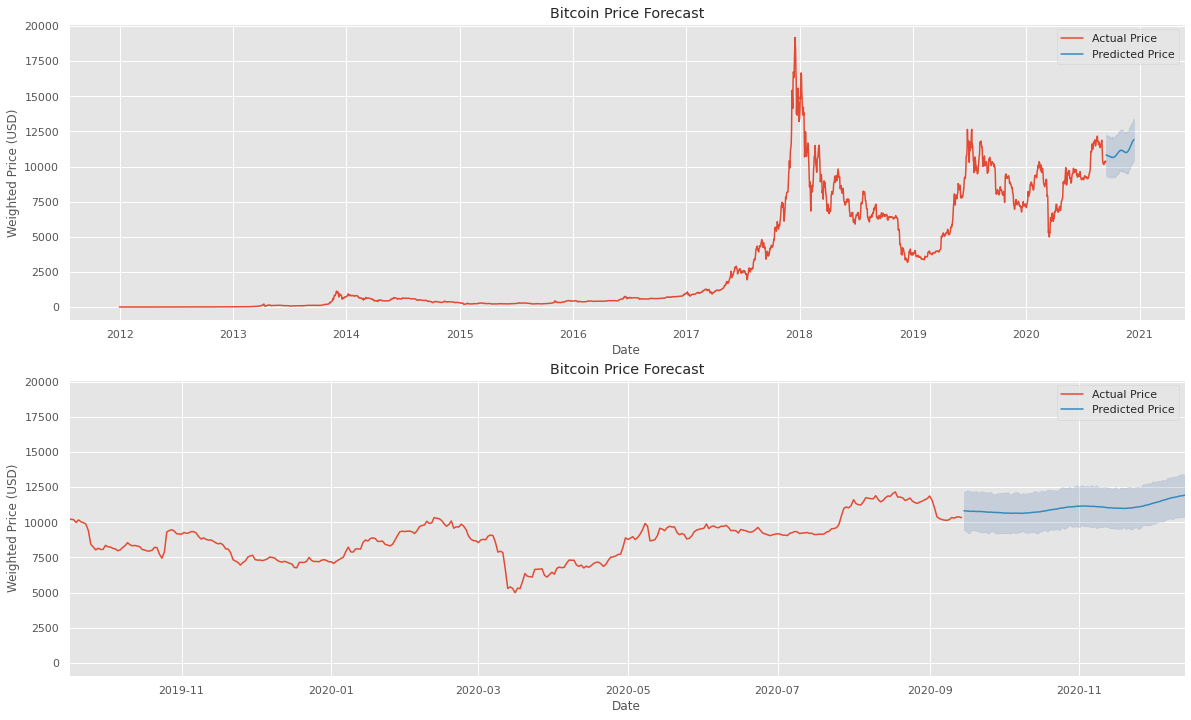

In [71]:
# Use function to make future predictions
y_test, y_pred_prophet_future  = prophet_forecast_future(train_df, future_df)

We have now forecasted Bitcoin prices for the next 3 months using the Prophet model. The forecast results suggest that Bitcoin will remain relatively stable and will fluctuate between approximately \$10,000 - $12,500, with a slight upward trend.  

## Discussion

### 2020 Bitcoin Prices
Let's compare the performance of our three models on actual 2020 Bitcoin prices. Recall that each RNN model was trained on data from before 2020, and predictions for each date were made with 60 days of prior information. In the case of the Prophet model, however, all prior information was used to inform the model's predictions.

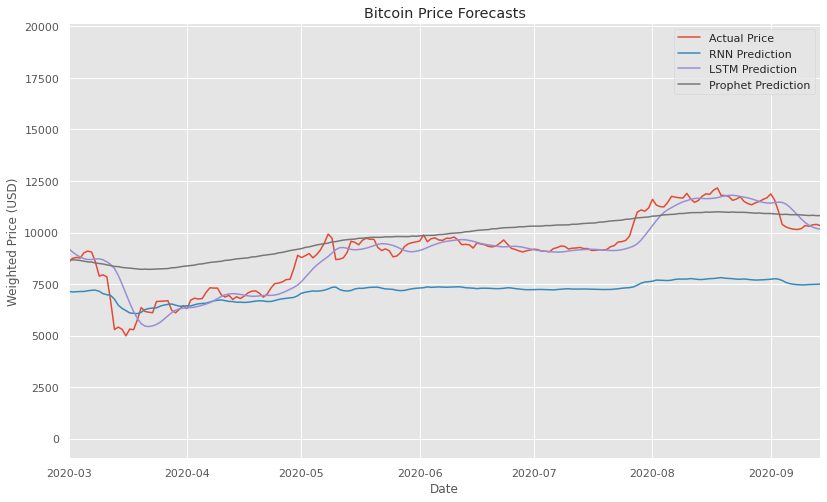

In [111]:
fig, ax = plt.subplots()

sns.lineplot(x = bitcoin['Date'], y = bitcoin['Weighted_Price'], ax =ax)
sns.lineplot(x = test_df['ds'][60:], y = y_pred_rnn[:, 0], ax =ax)
sns.lineplot(x = test_df['ds'][60:], y = y_pred_lstm[:, 0], ax =ax)
sns.lineplot(x = test_df['ds'][60:], y = y_pred_prophet.values[60:], ax =ax)
ax.legend(labels = ['Actual Price', 'RNN Prediction',
                    'LSTM Prediction', 'Prophet Prediction'])
ax.set_xlim(test_df['ds'][60:].min(), btc_test['Date'].max())

ax.set_title('Bitcoin Price Forecasts')
ax.set_ylabel('Weighted Price (USD)')
ax.set_xlabel('Date');

Our analysis found that the **LSTM model had the greatest test performance**, accurately predicting Bitcoin prices and trends. We can see that the LSTM forecast very closely fits the actual Bitcoin prices. Our results suggest that LSTM models are relatively very promising for forecasting Bitcoin prices; however, because RNN/LSTM models require specific data structures and make predictions one day at a time based on x timesteps (in our case, 60), it is very difficult to make future forecasts. This is because the models are trained sequentially, and thus, if we were to make predictions 30 days into the future, our predictions would become increasingly inaccurate as they become more and more dependent on extrapolated data. 

It is for this reason that we used the Prophet model to make predictions on future data, even though Prophet did not perform as well as LSTM on the actual 2020 data. Rather than training sequential learning models that are ideal for predicting one day at a time, Prophet focuses more on identifying linear and non-linear trends and seasonality. 

### Future Bitcoin Prices
Let's revisit our future Bitcoin price forecast using Prophet. 

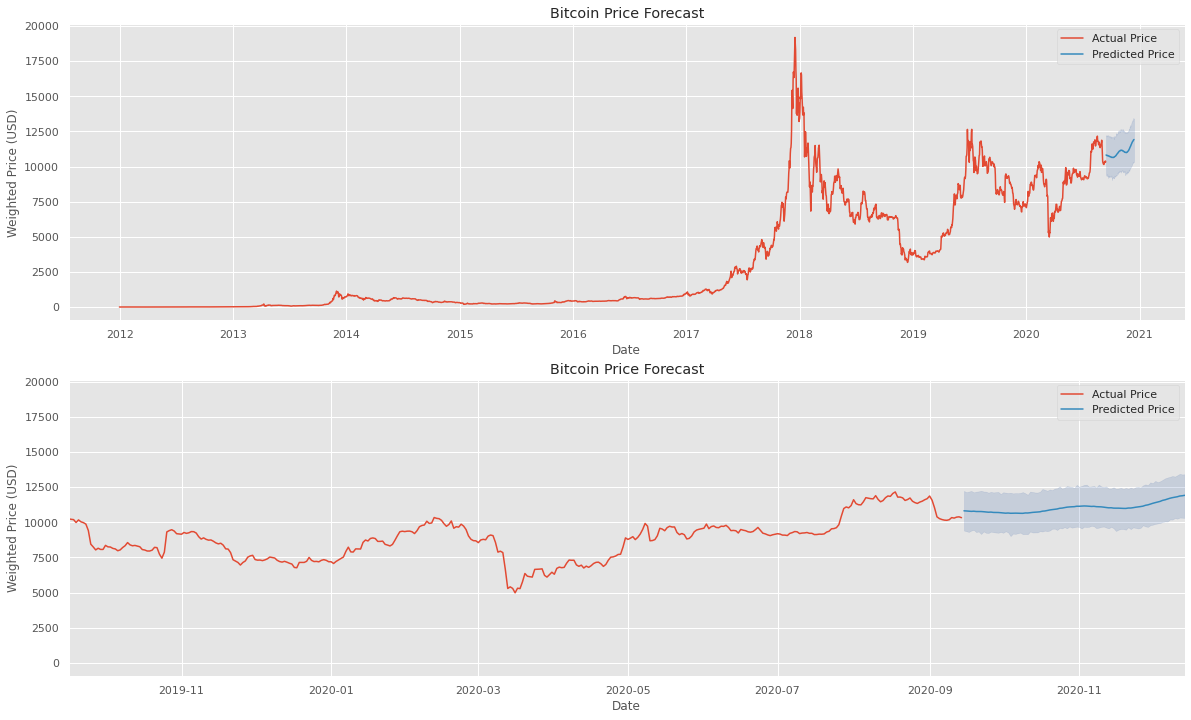

In [72]:
# Use function to make future predictions
y_test, y_pred_prophet_future  = prophet_forecast_future(train_df, future_df)

**Our Prophet forecast suggests that Bitcoin prices will remain relatively stable with a slight upward trend.** As we saw with our actual 2020 data, the Prophet model is generally accurate with predictions. However, there are certainly significant limitations to consider here. While Prophet has the capacity to take seasonality into consideration, forecasting predictions should still be taken with a grain of salt, as these models are unable to consider world events and public perceptions. If there are major shifts in the perceptions of Bitcoin or other cryptocurrencies, this may have an impact on prices. For example, if large companies continued to invest in Bitcoin, that would have a positive impact on Bitcoin prices; if, instead, companies decided to abandon Bitcoin, then that would likely result in a sharp decrease in Bitcoin prices.   

Despite the limitations, the Prophet model is still promising for enthusiasts who are curious about where Bitcoin's prices will go in the near future. Does this mean that we should make Bitcoin trading decisions based on these models? Not so much. 

## Takeaways
In this project, we developed three models for the prediction of Bitcoin prices. We found that our LSTM model had the strongest performance in predicting prices sequentially, but our Prophet model was able to learn general trends that may be more useful for long-term forecasting. We used the Prophet model to predict prices 3 months into the future, and found that Bitcoin prices are likely to stay relatively stable, with a slight upward trend. 

The goal of this project was to explore the capacity of various models to forecast Bitcoin prices, and we were very successful in this regard. We found that our LSTM and Prophet forecasts were able to accurately predict Bitcoin prices, suggesting that there are instrinsic characteristics of Bitcoin market trends that can be understood through modeling. The results of our analysis suggest that these novel forecasting techniques hold great promise for the future, despite significant limitations that remain at present day. 

In [112]:
!jupyter nbconvert --to markdown '/content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin/bitcoin-price-forecasting.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin/bitcoin-price-forecasting.ipynb to markdown
[NbConvertApp] Support files will be in bitcoin-price-forecasting_files/
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin/bitcoin-price-forecasting_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin/bitcoin-price-forecasting_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin/bitcoin-price-forecasting_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin/bitcoin-price-forecasting_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin/bitcoin-price-forecasting_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin/bitcoin-price-forecasting_files
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/P